In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 89% 132M/149M [00:01<00:00, 115MB/s] 
100% 149M/149M [00:01<00:00, 105MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

from skimage.feature import hog
from skimage import exposure

from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import zipfile


# Data Visulization

In [ ]:
def extract():
  zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
  zip_ref.extractall('/content')
  zip_ref.close()

In [ ]:

def display_few():
  from PIL import Image
  from IPython.display import display
  # Define the file paths
  file_path1 = '/content/Testing/glioma/Te-glTr_0000.jpg'
  file_path2 = '/content/Testing/meningioma/Te-meTr_0003.jpg'
  file_path3 = '/content/Testing/notumor/Te-noTr_0000.jpg'
  file_path4 = '/content/Testing/pituitary/Te-piTr_0000.jpg'

  pathList = [file_path1, file_path2, file_path3, file_path4]

  # Create an empty list to store the opened images
  images = []

  # Open and store the images in the list
  for path in pathList:
      img = Image.open(path)
      images.append(img)

  # Merge the images into a single display side by side
  tiled_img = Image.new('RGB', (sum(img.width for img in images), max(img.height for img in images)))
  x_offset = 0
  for img in images:
      tiled_img.paste(img, (x_offset, 0))
      x_offset += img.width

  # Display the merged image
  display(tiled_img)

In [ ]:
def load_dataframe(path):
  path
  labels=[]
  filepaths=[]
  folds=os.listdir(path)
  for fold in folds:
      foldpath=os.path.join(path,fold) #melengioma
      foldlist=os.listdir(foldpath)
      for file in foldlist:
          filepath=os.path.join(foldpath,file) #image path
          labels.append(fold)
          filepaths.append(filepath)
  l=pd.Series(labels,name="labels")
  f=pd.Series(filepaths,name="filepaths")
  tr_df=pd.concat([f,l],axis=1)
  return tr_df

def plot_df(df):
  fig,ax=plt.subplots(figsize=(9,3))
  fig.patch.set_facecolor("#f6f5f7")
  ax.set_facecolor("#f6f5f7")
  for i in ["top","right"]:
      ax.spines[i].set_visible(False)

  x = sns.countplot(data=df, y=df["labels"],palette='Blues')
  for container in x.containers:
      x.bar_label(container)
  plt.title("\nThe Count of images in each folder\n",weight="bold");

In [ ]:
extract()

In [ ]:
training_df = load_dataframe("/content/Training")
testing_df = load_dataframe("/content/Testing")

In [ ]:
print(training_df.head())
print(testing_df.head())

                                     filepaths      labels
0  /content/Training/meningioma/Tr-me_0893.jpg  meningioma
1  /content/Training/meningioma/Tr-me_0551.jpg  meningioma
2  /content/Training/meningioma/Tr-me_0562.jpg  meningioma
3  /content/Training/meningioma/Tr-me_0612.jpg  meningioma
4  /content/Training/meningioma/Tr-me_0984.jpg  meningioma
                                    filepaths      labels
0  /content/Testing/meningioma/Te-me_0153.jpg  meningioma
1  /content/Testing/meningioma/Te-me_0231.jpg  meningioma
2  /content/Testing/meningioma/Te-me_0223.jpg  meningioma
3  /content/Testing/meningioma/Te-me_0214.jpg  meningioma
4  /content/Testing/meningioma/Te-me_0238.jpg  meningioma


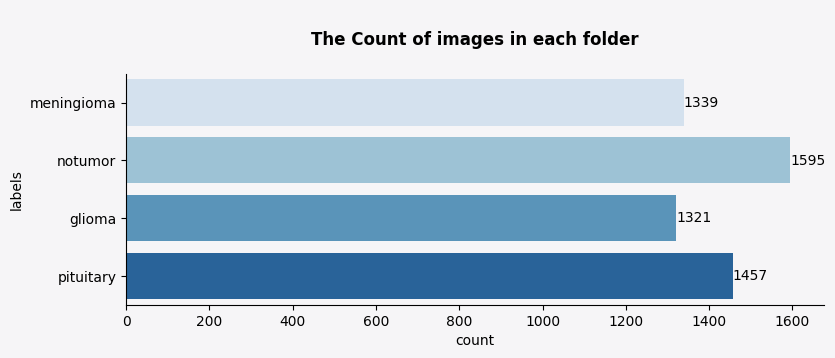

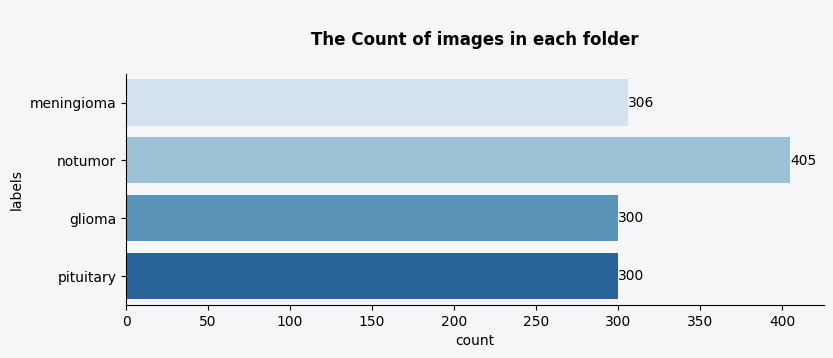

In [ ]:
plot_df(training_df)
plot_df(testing_df)

In [ ]:
# gen_dict = train_gen.class_indices
# print(gen_dict)
# classes = list(gen_dict.keys())
# images , labels = next(train_gen)

# plt.figure(figsize= (8,8))

# for i in range(16):
#     plt.subplot(4,4,i+1)
#     image = images[i] / 255
#     plt.imshow(image)
#     index = np.argmax(labels[i])
#     class_name = classes[index]
#     plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
#     plt.axis('off')
# plt.show()

In [ ]:
# def extract_hog_features(image):
#     # Convert the image to grayscale
#     if len(image.shape) > 2 and image.shape[2] == 4:  # Check for RGBA images
#         image_gray = rgb2gray(image[:, :, :3])  # Discard alpha channel
#     elif len(image.shape) > 2:  # Handle other multichannel images
#         image_gray = rgb2gray(image)
#     else:  # Grayscale images
#         image_gray = image

#     # Extract HOG features from the grayscale image
#     fd, hog_image = hog(image_gray, orientations=8, pixels_per_cell=(16, 16),
#                         cells_per_block=(1, 1), visualize=True, multichannel=False)
#     hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
#     return fd
# def load_data_with_hog(data_path,max_feature_length = 0):
#     labels = []
#     features = []
#     for class_name in os.listdir(data_path):
#         class_path = os.path.join(data_path, class_name)
#         for image_name in os.listdir(class_path):
#             image_path = os.path.join(class_path, image_name)
#             image = plt.imread(image_path)
#             hog_features = extract_hog_features(image)
#             features.append(hog_features)
#             if len(hog_features) > max_feature_length:
#                 max_feature_length = len(hog_features)
#             labels.append(class_name)

#     # Pad or truncate features to ensure they all have the same length
#     features = [np.pad(feature, (0, max_feature_length - len(feature))) for feature in features]

#     return np.array(features), np.array(labels),max_feature_length

In [ ]:
# # Define data paths
# train_data_path = '/content/Training'
# test_data_path = '/content/Testing'

# # Load training and testing data with HOG features
# X_data, y_data, max_feature_length = load_data_with_hog(train_data_path)
# X_test_data, y_test_data, max_feature_length = load_data_with_hog(test_data_path,max_feature_length)

# # Split training data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# # Convert labels to one-hot encoding
# y_train = pd.get_dummies(y_train)
# y_valid = pd.get_dummies(y_valid)
# y_test = pd.get_dummies(y_test_data)

# X_data.shape, X_test_data.shape

# Control CNN network

In [ ]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(training_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=32,shuffle=True,
                                 class_mode='categorical',color_mode="grayscale")


valid_gen=ts.flow_from_dataframe(training_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="grayscale",
                                 shuffle=True,batch_size=32,)


test_gen=ts.flow_from_dataframe(testing_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=32, shuffle=False,
                                 color_mode="grayscale", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
# Define the CNN model
def block(f):
  return [
        Conv2D(f,(3,3),padding='same'),
        Conv2D(f,(1,1),padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
      ]

model_cnn = Sequential([
    Conv2D(8,(3,3),input_shape=(224,224,1),padding='same'),
    *block(16),
    *block(16),
    *block(32),
    *block(32),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

In [ ]:
model_cnn.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_cnn = model_cnn.fit(train_gen, epochs=20, batch_size=32, validation_data=valid_gen, verbose=1)

Epoch 1/20
179/179 [==============================] - 32s 119ms/step - loss: 4.9329 - accuracy: 0.4510 - val_loss: 0.9734 - val_accuracy: 0.6420
Epoch 2/20
179/179 [==============================] - 19s 105ms/step - loss: 1.1123 - accuracy: 0.5578 - val_loss: 0.8559 - val_accuracy: 0.7050
Epoch 3/20
179/179 [==============================] - 21s 117ms/step - loss: 1.0386 - accuracy: 0.5846 - val_loss: 0.7743 - val_accuracy: 0.7211
Epoch 4/20
179/179 [==============================] - 19s 104ms/step - loss: 0.9399 - accuracy: 0.6248 - val_loss: 0.7149 - val_accuracy: 0.7572
Epoch 5/20
179/179 [==============================] - 21s 115ms/step - loss: 0.8750 - accuracy: 0.6544 - val_loss: 0.6453 - val_accuracy: 0.7691
Epoch 6/20
179/179 [==============================] - 21s 117ms/step - loss: 0.8393 - accuracy: 0.6654 - val_loss: 0.5517 - val_accuracy: 0.8150
Epoch 7/20
179/179 [==============================] - 19s 106ms/step - loss: 0.7962 - accuracy: 0.6871 - val_loss: 0.5127 - val_ac

In [ ]:
model_cnn.evaluate(test_gen)
predicted_lab = model_cnn.predict(test_gen)


41/41 [==============================] - 2s 42ms/step


In [ ]:
print(predicted_lab[:2])
out_cnn = np.array([list(train_gen.class_indices.keys())[pred.argmax()] for pred in predicted_lab])
print(out_cnn)
print(testing_df['labels'].values)

[[1.5248261e-01 8.4694684e-01 1.9293954e-04 3.7756283e-04]
 [9.7651690e-02 2.2547157e-01 2.5165206e-01 4.2522469e-01]]
['meningioma' 'pituitary' 'meningioma' ... 'meningioma' 'pituitary'
 'pituitary']
['meningioma' 'meningioma' 'meningioma' ... 'pituitary' 'pituitary'
 'pituitary']


In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      272       
                                                        

# HOG enabled NN

In [ ]:
LE = LabelEncoder()

training_y = LE.fit_transform(training_df["labels"])
training_x = training_df["filepaths"]

testing_y = LE.transform(testing_df["labels"])
testing_x = testing_df['filepaths']

train_x, valid_x, train_y ,valid_y = train_test_split(training_x,training_y,test_size=0.2,random_state=50)

In [ ]:
def load_image(path,target_size):
  image = tf.keras.utils.load_img(path,color_mode="grayscale",target_size=target_size)
  input_arr = tf.keras.utils.img_to_array(image)
  return input_arr

def preprocess_images_hog(path):
  img_gray = load_image(path,(224,224))[:,:,0]
  fd = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=False, multichannel=False)
  return fd

In [ ]:
train_inp = np.array([ preprocess_images_hog(f) for f in train_x ])
train_lab = pd.get_dummies(train_y).values
print(train_inp.shape)

valid_inp = np.array([ preprocess_images_hog(f) for f in valid_x ])
valid_lab = pd.get_dummies(valid_y).values
print(valid_inp.shape)

ts_inp = np.array([ preprocess_images_hog(f) for f in testing_x ])
ts_lab = pd.get_dummies(testing_y).values
print(ts_inp.shape)

(4569, 1568)
(1143, 1568)
(1311, 1568)


In [ ]:
model_hog = Sequential([
    Dense(128, activation='relu',input_shape=(int(train_inp.shape[1]),)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

In [ ]:
model_hog.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],run_eagerly=True)

In [ ]:
print(train_inp[:2],train_lab[:2])

[[0.40642327 0.26712054 0.40642327 ... 0.3590651  0.3590651  0.3590651 ]
 [0.5736807  0.19824381 0.2507608  ... 0.11217419 0.27872294 0.5117363 ]] [[False False False  True]
 [False False False  True]]


In [ ]:
history_hog = model_hog.fit(x=train_inp,y=train_lab, epochs=20, batch_size=32, validation_data=(valid_inp,valid_lab), verbose=1)

Epoch 1/20
143/143 [==============================] - 5s 31ms/step - loss: 0.9812 - accuracy: 0.5837 - val_loss: 0.6496 - val_accuracy: 0.7717
Epoch 2/20
143/143 [==============================] - 4s 31ms/step - loss: 0.6849 - accuracy: 0.7439 - val_loss: 0.5065 - val_accuracy: 0.8548
Epoch 3/20
143/143 [==============================] - 4s 29ms/step - loss: 0.5612 - accuracy: 0.8041 - val_loss: 0.4297 - val_accuracy: 0.8679
Epoch 4/20
143/143 [==============================] - 5s 32ms/step - loss: 0.5012 - accuracy: 0.8201 - val_loss: 0.4050 - val_accuracy: 0.8618
Epoch 5/20
143/143 [==============================] - 4s 27ms/step - loss: 0.4595 - accuracy: 0.8402 - val_loss: 0.3679 - val_accuracy: 0.8828
Epoch 6/20
143/143 [==============================] - 4s 28ms/step - loss: 0.4226 - accuracy: 0.8492 - val_loss: 0.3616 - val_accuracy: 0.8801
Epoch 7/20
143/143 [==============================] - 5s 32ms/step - loss: 0.3977 - accuracy: 0.8577 - val_loss: 0.3494 - val_accuracy: 0.8880

In [ ]:
model_hog.evaluate(ts_inp,ts_lab)
predicted_hog = model_hog.predict(ts_inp)

41/41 [==============================] - 0s 4ms/step


In [ ]:
print(predicted_hog[:2])
out_hog = np.array([list(train_gen.class_indices.keys())[pred.argmax()] for pred in predicted_hog])
print(out_hog)
print(LE.inverse_transform(testing_y))

[[0.00921116 0.96781456 0.00544006 0.01753428]
 [0.06208354 0.52295804 0.00670245 0.40825593]]
['meningioma' 'meningioma' 'glioma' ... 'pituitary' 'pituitary'
 'pituitary']
['meningioma' 'meningioma' 'meningioma' ... 'pituitary' 'pituitary'
 'pituitary']


In [ ]:
model_hog.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               200832    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 209348 (817.77 KB)
Trainable params: 209348 (817.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Metrics

In [ ]:
def generate_report(y_true, y_pred, labels):
  cm = confusion_matrix(y_true,y_pred, labels=labels)
  cr = classification_report(y_true,y_pred, target_names=labels)
  print(cm)
  print()
  print(cr)

def plot_history(his):
  loss = his.history["loss"]
  val_loss = his.history["val_loss"]
  accuracy = his.history["accuracy"]
  val_accuracy = his.history["val_accuracy"]

  plt.figure()
  plt.title("Loss vs Epoch")
  plt.plot(loss,c='r',label="train loss")
  plt.plot(val_loss,c='b',label='val loss')
  plt.legend()

  plt.figure()
  plt.title("Accuracy vs Epoch")
  plt.plot(accuracy,c='r',label='train acc')
  plt.plot(val_accuracy,c='b',label='val acc')
  plt.legend()

In [ ]:
print("-"*50,"CNN","-"*50)
generate_report(testing_df['labels'].values,out_cnn,list(train_gen.class_indices.keys()))
print("-"*50,"HOG","-"*50)
generate_report(LE.inverse_transform(testing_y),out_hog,list(train_gen.class_indices.keys()))

-------------------------------------------------- CNN --------------------------------------------------
[[231  66   1   2]
 [ 20 233  39  14]
 [  2   4 399   0]
 [  0  10   0 290]]

              precision    recall  f1-score   support

      glioma       0.91      0.77      0.84       300
  meningioma       0.74      0.76      0.75       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.95      0.97      0.96       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311

-------------------------------------------------- HOG --------------------------------------------------
[[250  43   0   7]
 [ 34 166  76  30]
 [  0   1 404   0]
 [  5   4   0 291]]

              precision    recall  f1-score   support

      glioma       0.87      0.83      0.85       300
  meningioma       0.78      0.54      0.64       306
     notumor       0.84      1.00 

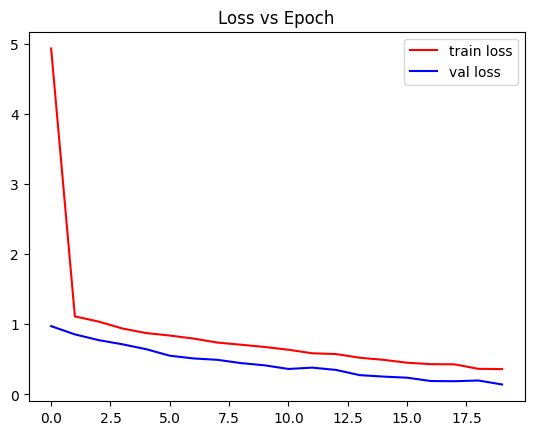

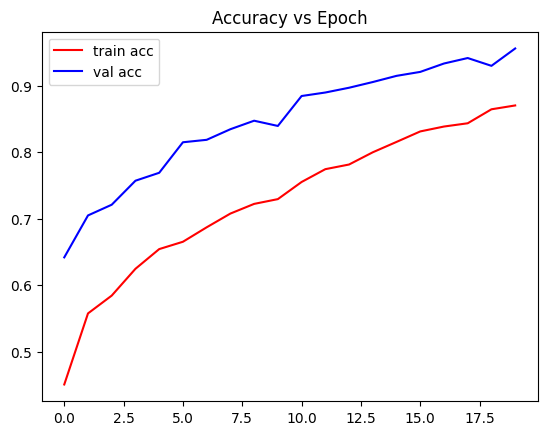

In [ ]:
plot_history(history_cnn)

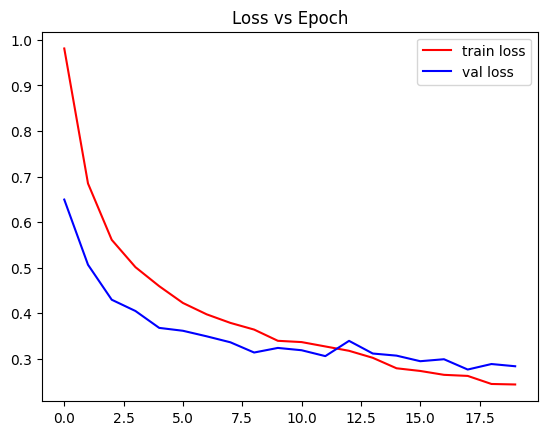

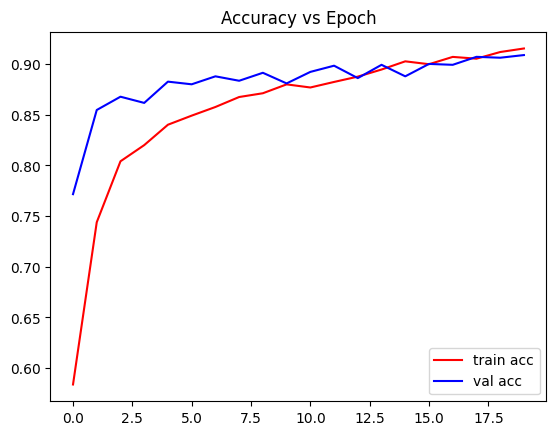

In [ ]:
plot_history(history_hog)